# Modelo de Clasificación KNN para Sales Price


In [18]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [3]:
df = pd.read_csv("train.csv")

In [ ]:
variables_numericas = [
    'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF',
    '1stFlrSF', 'FullBath', 'YearBuilt', 'KitchenAbvGr',
    'TotRmsAbvGrd', 'Fireplaces', 'SalePrice'
]

df = df[variables_numericas]


#### Creación de variable categórica


In [9]:
p40 = df['SalePrice'].quantile(0.40)
p90 = df['SalePrice'].quantile(0.90)

def clasificar_precio(precio: float) -> str:
    if precio <= p40:
        return "Económica"
    elif precio <= p90:
        return "Intermedia"
    else:
        return "Cara"

df['CategoriaPrecio'] = df['SalePrice'].apply(clasificar_precio)

In [7]:
X = df.drop(['SalePrice', 'CategoriaPrecio'], axis=1)
y = df['CategoriaPrecio']

#### Separación entre train y test


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

#### Normalización de datos


In [11]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### Probando variables k


In [12]:
accuracies = []
cv_scores = []
k_values = range(1, 41)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, p=2, metric='euclidean')  
    knn.fit(X_train, y_train)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores.append(np.mean(scores))
    y_pred = knn.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_pred))

#### Gráfica de presición de modelo según K


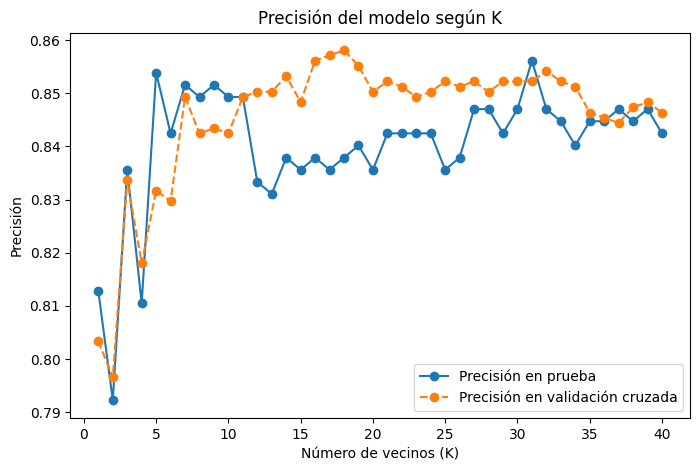

In [17]:
plt.figure(figsize=(8, 5))
plt.plot(k_values, accuracies, marker='o', label="Precisión en prueba")
plt.plot(k_values, cv_scores, marker='o', linestyle="dashed", label="Precisión en validación cruzada")
plt.xlabel('Número de vecinos (K)')
plt.ylabel('Precisión')
plt.title('Precisión del modelo según K')
plt.legend()
plt.show()

#### Encontrar mejor valor de k basado en validación cruzada


In [34]:
best_k = k_values[np.argmax(cv_scores)]
print(f"Mejor valor de K según CV=5: {best_k}")

Mejor valor de K según CV=5: 18


#### Verificando k óptimo


In [35]:
print(f"Aproximación de K usando sqrt(N_test): {math.sqrt(len(y_test)):.2f}")

Aproximación de K usando sqrt(N_test): 20.93


#### Definiendo modelo con mejor K encontrado


In [48]:
knn = KNeighborsClassifier(n_neighbors=best_k, p=2, metric='euclidean')
knn.fit(X_train, y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=18)

In [49]:
y_pred = knn.predict(X_test)

#### Reporte de clasificación y precisión


In [52]:
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print(f"\nPrecisión del modelo final (K={best_k}): {accuracy:.2f}")


Reporte de Clasificación:
              precision    recall  f1-score   support

        Cara       0.75      0.77      0.76        43
   Económica       0.83      0.90      0.86       177
  Intermedia       0.87      0.80      0.83       218

    accuracy                           0.84       438
   macro avg       0.81      0.82      0.82       438
weighted avg       0.84      0.84      0.84       438


Precisión del modelo final (K=18): 0.84


#### Matriz de confusión


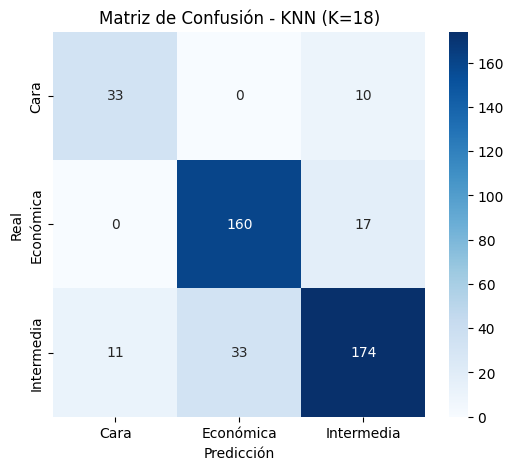

In [54]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title(f"Matriz de Confusión - KNN (K={best_k})")
plt.show()

<small>

### Análisis de Matriz de Confusión

Se utilizó un modelo de **K-Nearest Neighbors (KNN) con K=18** para clasificar las casas en **Económicas, Intermedias y Caras**. La matriz de confusión muestra el rendimiento del modelo en cada categoría.

| **Métrica**                     | **Valor**                |
| ------------------------------- | ------------------------ |
| **Precisión Global (Accuracy)** | 82%                      |
| **Clases con menor error**      | Económicas e Intermedias |
| **Clases con mayor error**      | Caras                    |

#### **Desempeño por Categoría**

La matriz de confusión permite analizar dónde el modelo hizo buenas predicciones y dónde se equivocó.

**Casas Económicas (Mejor desempeño)**

- **Correctas:** 160 de 177 casas económicas fueron clasificadas correctamente.
- **Errores:** Solo 17 casas (9.6%) fueron mal clasificadas como Intermedias.
- **Conclusión:** El modelo tiene un alto nivel de precisión en esta categoría y rara vez confunde casas económicas con otras clases.

**Casas Intermedias (Rendimiento medio)**

- **Correctas:** 174 de 218 casas intermedias fueron clasificadas correctamente.
- **Errores:**
  - 33 casas intermedias (15.1%) fueron mal clasificadas como **Económicas**.
  - 11 casas intermedias (5%) fueron mal clasificadas como **Caras**.
- **Conclusión:** Aunque el modelo logra identificar bien la mayoría de las casas intermedias, comete errores al confundir algunas con casas económicas.

**Casas Caras (Mayor error)**

- **Correctas:** 33 de 43 casas caras fueron clasificadas correctamente.
- **Errores:**
  - 10 casas caras (23%) fueron mal clasificadas como **Intermedias**.
- **Conclusión:** El modelo tiene dificultades para distinguir casas caras de intermedias, lo que puede deberse a la similitud en algunas características físicas entre ambas clases.

#### **Importancia de los Errores**

- **El error más crítico:**
  - Casas caras mal clasificadas como intermedias (23%).
  - **Impacto:** Puede afectar la tasación de propiedades en aplicaciones comerciales.
- **Errores entre intermedias y económicas:**
  - 33 casas intermedias clasificadas como económicas (15.1%).
  - **Impacto:** Puede afectar estudios de mercado y segmentación.
- **Clasificación de casas económicas (90.4% correcta)** es **muy confiable** y el modelo rara vez se equivoca en esta categoría.

#### **Conclusión Final**

- El modelo es altamente preciso (90.4%) en identificar casas económicas.
- Tiene un desempeño aceptable con casas intermedias, pero con margen de mejora.
- El modelo se equivoca más en casas caras, confundiéndolas con intermedias (23% de error).

</small>
